Model Simple + Prendre en compte la taille des champs Designation et description

In [1]:
import importlib

import RktnChallenge.RktnModel
importlib.reload(RktnChallenge.RktnModel)
from RktnChallenge.RktnModel import ModelTrainer


from RktnChallenge.preprocessing.tokenizeString import tokenizeString
from RktnChallenge.preprocessing.filterStopWords import filterStopWords
from RktnChallenge.preprocessing.mergeFeatures import mergeFeatures
from RktnChallenge.preprocessing.mostOccur import mostOccur
from RktnChallenge.preprocessing.Dropper import Dropper
from RktnChallenge.preprocessing.TokenListToString import TokenListToString



import RktnChallenge.preprocessing.filterChar
importlib.reload(RktnChallenge.preprocessing.filterChar)
from RktnChallenge.preprocessing.filterChar import filterChar

import RktnChallenge.preprocessing.lemmatize
importlib.reload(RktnChallenge.preprocessing.lemmatize)
from RktnChallenge.preprocessing.lemmatize import lemmatize

import RktnChallenge.preprocessing.regularExprSub
importlib.reload(RktnChallenge.preprocessing.regularExprSub)
from RktnChallenge.preprocessing.regularExprSub import regularExprSub

2023-09-08 14:41:22.193980: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-08 14:41:22.223543: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 14:41:22.738006: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-08 14:41:24.667270: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-08 1

In [2]:
import pandas as pd
RktnModel = ModelTrainer("data_tr_lemm.csv")
RktnModel.data['description_length'] = RktnModel.data['description'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
RktnModel.data['designation_length'] = RktnModel.data['designation'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

min_val = RktnModel.data['description_length'].min()
max_val = RktnModel.data['description_length'].max()
RktnModel.data['description_length_normalized'] = (RktnModel.data['description_length'] - min_val) / (max_val - min_val)

min_val = RktnModel.data['designation_length'].min()
max_val = RktnModel.data['designation_length'].max()
RktnModel.data['designation_length_normalized'] = (RktnModel.data['designation_length'] - min_val) / (max_val - min_val)




RktnModel.data = RktnModel.data.drop_duplicates(subset=['designation', 'description'])
print(RktnModel.data.shape)

(83493, 27)


Vectorization des données

In [3]:
_X = RktnModel.data["merged_desi_desc"]

RktnModel.create_vectorizer(name="tokenizer", X = _X, ngram_range=(1,3))

X_data = RktnModel.vectorizer_transform(_X)     


y = RktnModel.encodeLabel("prdtypecode")
label_size = RktnModel.getLabelSize()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size = 0.20, random_state = 42)

desi_data = RktnModel.data['designation_length']
desi_train, desi_test= train_test_split(desi_data, test_size = 0.20, random_state = 42)

desc_data = RktnModel.data['description_length']
desc_train, desc_test= train_test_split(desc_data, test_size = 0.20, random_state = 42)


# calcul des poids de chaque classe à appliquer
from collections import Counter

class_counts = Counter(y_test)
total_samples = len(y_test)

class_weights = {}
for class_num, count in class_counts.items():
    class_weights[class_num] = total_samples / (27 * count)
    
display(class_weights)

{15: 3.7034819250388114,
 24: 1.1986075222509331,
 20: 2.0015581924967036,
 23: 0.3286299051442516,
 22: 1.2419306857057861,
 6: 4.2073570168808265,
 7: 0.6317481935459464,
 2: 1.9148033482398807,
 14: 0.7626158834543545,
 1: 1.2295854502613945,
 9: 0.6069494420819249,
 12: 0.9456903386566995,
 8: 1.431670096021948,
 4: 1.1986075222509331,
 26: 3.7943649170643035,
 21: 0.628538090936465,
 13: 0.6022215009556782,
 19: 0.6442515432098765,
 10: 4.721232683064744,
 18: 0.6483034397080518,
 16: 0.6489837161400646,
 25: 1.1625591757170703,
 0: 0.9943432178158866,
 3: 3.474615064502705,
 5: 0.7898869495293506,
 11: 1.25707618187293,
 17: 3.7712285456187895}

Definition d'un modele

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Flatten, Input, concatenate, Dropout

_latent_dim = 600
vocab_size = RktnModel.vocab_size
print(vocab_size)
max_seq_length = RktnModel.max_seq_length

# Entrée de texte
text_input = Input(shape=(max_seq_length,), name='text_input')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=_latent_dim, input_length=max_seq_length, mask_zero=True)(text_input)
flattened_embedding = Flatten()(embedding_layer)

# Deux entrées d'entiers
int_input1 = Input(shape=(1,), name='length_input')
int_input2 = Input(shape=(1,), name='length_input2')

# Concaténation des trois entrées
concatenated = concatenate([flattened_embedding, int_input1, int_input2])
# Passez par un Dense pour obtenir la sortie
output = Dense(units=label_size, activation="softmax")(concatenated)

model = tf.keras.Model(inputs=[text_input, int_input1, int_input2], outputs=output)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])




142167


2023-09-08 14:41:44.978958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-08 14:41:44.979442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-08 14:41:44.979839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-08 14:41:46.411605: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-08 14:41:46.411884: I tensorflow/compile

In [5]:



model.fit([X_train, desi_train, desc_train], y_train, epochs=2, batch_size=1000,validation_split=0.2, class_weight=class_weights)

Epoch 1/2


2023-09-08 14:41:53.553321: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6d80002f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-08 14:41:53.553373: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN X (Pascal), Compute Capability 6.1
2023-09-08 14:41:53.557579: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-08 14:41:54.845823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-08 14:41:54.924838: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/54 [==============================] - 294s 5s/step - loss: 6.6983 - accuracy: 0.2101 - val_loss: 1.6689 - val_accuracy: 0.5951
Epoch 2/2
54/54 [==============================] - 333s 6s/step - loss: 1.1344 - accuracy: 0.7534 - val_loss: 0.8703 - val_accuracy: 0.7736


In [12]:
model.fit([X_train, desi_train, desc_train], y_train, epochs=1, batch_size=1000,validation_split=0.2)

54/54 [==============================] - 586s 11s/step - loss: 0.0635 - accuracy: 0.9913 - val_loss: 0.5630 - val_accuracy: 0.8363


522/522 [==============================] - 9s 18ms/step
weighted F1 score: 0.832983955521885


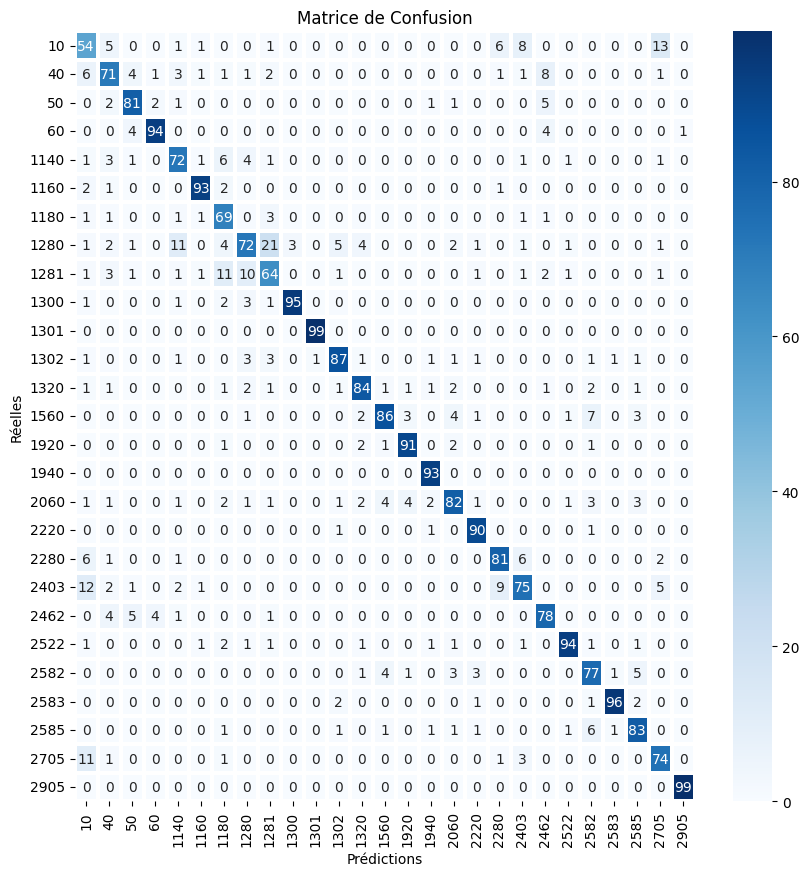

In [13]:
y_pred_test = model.predict([X_test,desi_test,desc_test])
y_pred_id = y_pred_test.argmax(axis=-1)

RktnModel.evaluateTestResults(y_test,y_pred_id)

209
